In [1]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from langdetect import detect
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt


In [2]:
def fetch_youtube_comments(api_key, education_query, max_results=50):
    # Create a YouTube API client
    youtube = build('youtube', 'v3', developerKey=api_key)

    
    comments_dataset = []

    try:
       
        search_response = youtube.search().list(
            q=education_query,
            type="video",
            part=["snippet"],
            maxResults=max_results,
            relevanceLanguage='en'  
        ).execute()

        
        for item in search_response.get('items', []):
            video_title = item['snippet']['title']
            video_id = item['id']['videoId']
            video_link = f'https://www.youtube.com/watch?v={video_id}'

            # Get comments for the video
            comments_request = youtube.commentThreads().list(
                part='snippet',
                videoId=video_id,
                textFormat='plainText'
            )

            try:
                comments_response = comments_request.execute()

               
                for comment in comments_response.get('items', []):
                    comment_text = comment['snippet']['topLevelComment']['snippet']['textDisplay']

                   
                    try:
                        comment_language = detect(comment_text)
                        if comment_language == 'en':
                            comments_dataset.append({'video_id': video_id, 'video_link': video_link, 'comment': comment_text})
                    except:
                        pass  

            except HttpError as e:
                print(f"HttpError during comments request:")

    except HttpError as e:
        print(f"HttpError during search request:")

   
    df_comments = pd.DataFrame(comments_dataset)

    return df_comments

api_key = your_api_key
education_query = 'java_course'
df_comments = fetch_youtube_comments(api_key, education_query)

In [3]:
def analyze_sentiment(df_comments):
    
    grouped_df = df_comments.groupby('video_id').filter(lambda x: len(x) >= 4)

    analyzer = SentimentIntensityAnalyzer()

    def get_sentiment_label(compound_score):
        if compound_score >= 0.05:
            return 'Positive'
        elif -0.05 < compound_score < 0.05:
            return 'Neutral'
        else:
            return 'Negative'

    grouped_df['sentiment_score'] = grouped_df['comment'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    
    grouped_df['sentiment_label'] = grouped_df['sentiment_score'].apply(get_sentiment_label)

    return grouped_df[['video_id', 'comment', 'sentiment_score', 'sentiment_label']]
    
grouped_df = analyze_sentiment(df_comments)

In [4]:
sentiment_bias = grouped_df['sentiment_label'].value_counts(normalize=True)
print("\nSentiment Bias:")
print(sentiment_bias)




Sentiment Bias:
Positive    0.637899
Neutral     0.279550
Negative    0.082552
Name: sentiment_label, dtype: float64


In [5]:
# Calculate sentiment metrics
sentiment_metrics = grouped_df.groupby('video_id')['sentiment_label'].value_counts(normalize=True).unstack().fillna(0)
print("\nSentiment Metrics :\n")
print(sentiment_metrics)



Sentiment Metrics :

sentiment_label  Negative   Neutral  Positive
video_id                                     
6GJ5upMzC7A      0.000000  0.416667  0.583333
7yf6676xMhM      0.000000  0.071429  0.928571
9HlQL8Bi1Dk      0.000000  0.250000  0.750000
9UVPAUA_TQE      0.200000  0.200000  0.600000
Ae-r8hsbPUo      0.062500  0.187500  0.750000
BGTx91t8q50      0.000000  0.125000  0.875000
Byf6xOYdNcw      0.000000  0.166667  0.833333
CFD9EFcNZTQ      0.000000  0.266667  0.733333
CqeyR6GjxkU      0.250000  0.250000  0.500000
F2nLupE7E4g      0.100000  0.300000  0.600000
GoXwIVyNvX0      0.153846  0.307692  0.538462
KkGpTzCNDSA      0.052632  0.421053  0.526316
LC8wLYvJ9po      0.000000  0.555556  0.444444
LusTv0RlnSU      0.166667  0.416667  0.416667
M3v0eGYxgRs      0.000000  0.500000  0.500000
NxOUYgai3Gs      0.083333  0.583333  0.333333
QrveTEKFnTU      0.111111  0.500000  0.388889
REj0eVDXX_w      0.125000  0.250000  0.625000
RRubcjpTkks      0.235294  0.294118  0.470588
SW6btyQjY_0 

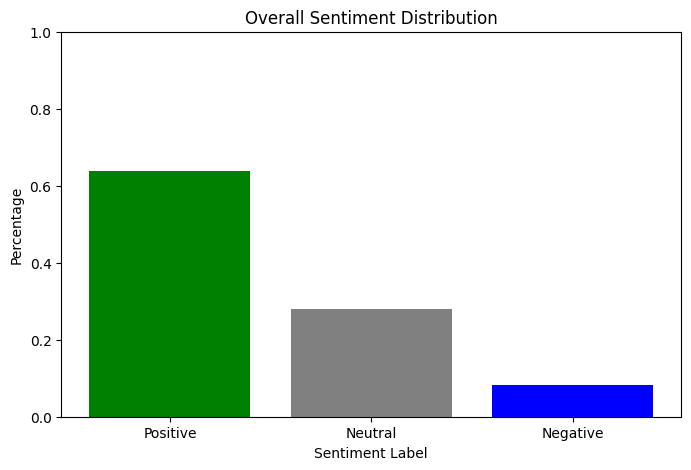

In [6]:
# Visualize overall sentiment distribution
overall_sentiment_metrics = grouped_df['sentiment_label'].value_counts(normalize=True)


plt.figure(figsize=(8, 5))
plt.bar(overall_sentiment_metrics.index, overall_sentiment_metrics, color=['green', 'gray', 'blue'])
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Percentage')
plt.ylim(0, 1)  
plt.show()


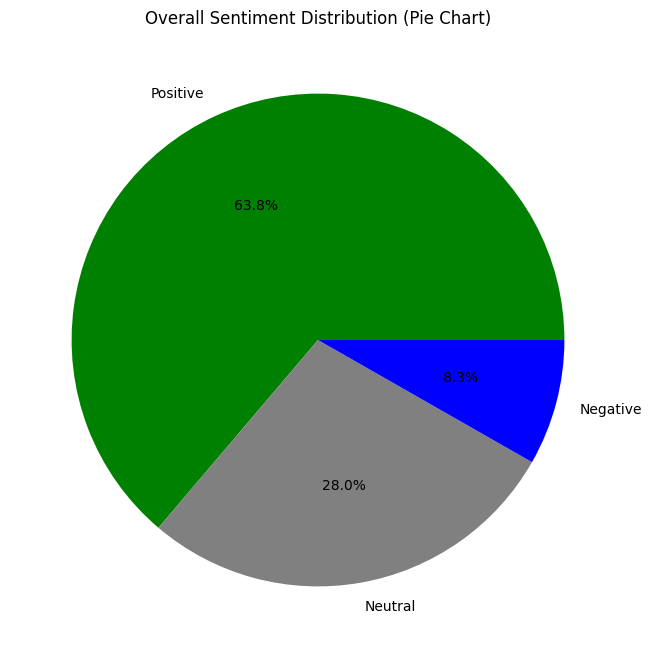

In [7]:
# Visualize overall sentiment distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(overall_sentiment_metrics, labels=overall_sentiment_metrics.index, autopct='%1.1f%%', colors=['green', 'gray', 'blue'])
plt.title('Overall Sentiment Distribution (Pie Chart)')
plt.show()
